# Lesson 1: Getting Started

In lesson 1 we walked through the process of creating a very simple image classifier, using high-level fast.ai features to abstract away a lot of the complexity. We walked through how to acquire and load a dataset, how to load a pre-trained model, and how to tune the model for our specific use-case.

In this mini-project I'll be using some of the same techniques to build my own image classifier for a more complex classification problem.

In [3]:

# I'll use this DuckDuckGo package to search for and get the url of images in order to construct our dataset
from duckduckgo_search import ddg_images

# Once we have image URLs, I'll use fastdownload to download the images so we can access them locally
from fastdownload import download_url

# And since this is a fast.ai course, I'll of course be making heavy use of the fast.ai library
from fastcore.all import *
from fastai.vision.all import *



First I need to decide what I'd like to classify with this model. In lecture we built a model to classify birds (or "not birds"). I think it'd be interesting to see if a pre-trained model can succeed at a slightly harder problem -- differentiating between different types of the same object. Namely, I'll be building a classifier to distinguish between different makes of cars.

I'll consider cars from the brands Ford (USA), Honda (Japan), Porsche (Germany), and Maserati (Italy) in order to diversify across manufacturors from 4 different countries. In order to make sure I have a wide range of cars from each manufacturer, I'll search for cars from the years spanning from 2010-2022.

In [4]:
years = [y for y in range(2010, 2023)]
brands = ['Honda', 'Ford', 'Porsche', 'Maserati']

Now let's grab the images! First let's make sure our plan for search terms yields good results. I actually had some access/corruption issues for images from older years and various websites, so I decided to tack on "kbb.com" (a popular car database site) to my search query, which really seemed to help mitigate that problem.

In [5]:

import ipyplot

# we'll use this helper function from the lesson to search for and retrieve urls for images
def search_images(term, max_images=30):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')


urls = search_images('2010 Porsche "kbb.com"', max_images=10)
ipyplot.plot_images(urls, max_images=10, img_width=200)
    

These images look great, now I can go about building a training set. With a few lines of code I can download all of the images to a directory on my local machine with DuckDuckGo:

In [6]:
from time import sleep
path = Path('car_brands')

for brand in brands:
    p = path/brand
    dest = (p)
    dest.mkdir(parents=True, exist_ok=True)
    for year in years:
        download_images(dest, urls=search_images(f'{year} {brand} "kbb.com"'), max_pics=100)
        sleep(10)
    resize_images(p, max_size=800, dest=p)
        

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


I'll need to make sure that there aren't any corrupted images in my dataset. I can do this by using the verify_images function from fastai. This code finds any images that can't properly be opened and removes them from the directory. 

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#451) [None,None,None,None,None,None,None,None,None,None...]

Now I can use a fastai DataLoader to create a training & validation set with the downloaded images. Sometimes the features that differentiate cars are quite small so I've chosen to keep the image resolution a bit larger than the example in class (480x480). My hypothesis is this will result in better accuracy, but at the cost of longer training times.

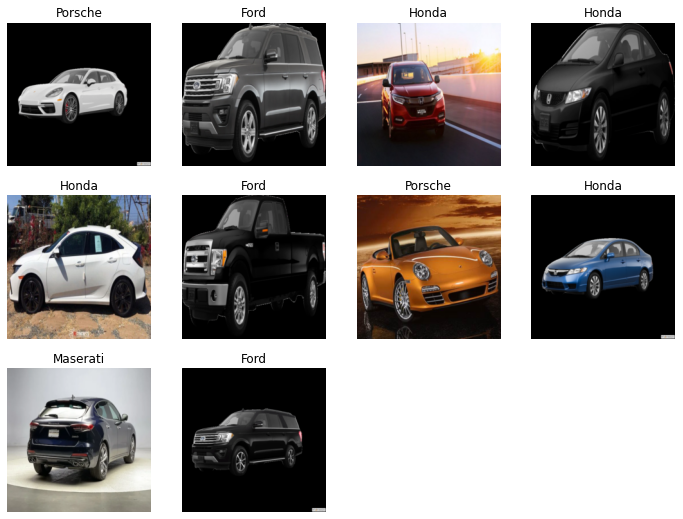

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=78),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)

Looks good! Next, I'll load the model and train it! Setting this all up by hand can be cumbersome so it's nice that fastai allows us to do all this in 2 lines of code!! Rather than having to train my own model, we can use an existing image classifier model *resnet18*. This model was trained to classify images into 1000 different categories, rather than 4 makes of car. However, some of the underlying features that the model learned will likely be useful for different classification tasks such as ours. Since this resnet model has already done a lot of the hard work in recognizing shapes, edges, and are features that makes up larger images, we can use it as a starting point and modify the network to fit our specific use-case. This is called *transfer learning*. Fastai makes this easy by wrapping the whole process into *fine_tune*, which we will run for 5 epochs. 

In [24]:
learn = vision_learner(dls, 'resnet18', metrics=error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.634517,0.474095,0.195349,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.640553,0.416149,0.153488,00:11
1,0.490601,0.433667,0.158140,00:10
2,0.367654,0.403276,0.148837,00:10
3,0.274624,0.337350,0.139535,00:11
4,0.204168,0.352190,0.139535,00:10


86% accuracy is not bad -- certainly better than I might have expected. Let's try choosing a larger, higher-accuracy pre-trained model to see if it can achieve even better results. I'll try using a larger *convnext* model instead.

In [26]:
# It's important you run empty_cache() first, and then gc.collect() !! 
# If you run them in reverse order no memory will be freed (this might be just on kaggle, ymmv)
# This stumped me for the longest time
torch.cuda.empty_cache()
import gc
gc.collect()

7439

In [27]:
learn = vision_learner(dls, 'convnext_large_in22ft1k', metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.929966,0.263332,0.097674,00:25


epoch,train_loss,valid_loss,error_rate,time
0,0.226355,0.202193,0.060465,00:58
1,0.181806,0.180424,0.041860,00:58
2,0.120926,0.144742,0.032558,00:58
3,0.093054,0.147352,0.041860,00:59
4,0.062541,0.142704,0.041860,00:58


Wow, this is much more accurate! I'm excited to see what our performance looks like on some new data.

Let's try pulling in some 2023 models and see how our classifier does on out-of-sample data. This is a particularly interesting test because zero 2023 cars were included in the training set, given we only considered up to the year 2022. Hopefully our model is able to generalize well!

In [19]:
from PIL import Image

brands.sort()

images = []
for brand in brands:
    url = search_images(f'2023 {brand} "kbb.com"', max_images=1)[0]
    dest = f'2023_{brand}.jpg'
    download_url(url, dest, show_progress=False)
    images.append(dest)

Predicted: Ford, actual: Ford.
Probability it's a Ford: 0.9995


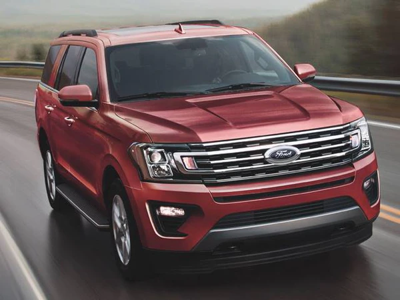

In [20]:
pred_class,_,probs = learn.predict(PILImage.create(images[0]))
print(f"Predicted: {pred_class}, actual: {brands[0]}.")
print(f"Probability it's a {brands[0]}: {probs[0]:.4f}")
Image.open(images[0]).to_thumb(400,400)

Predicted: Honda, actual: Honda.
Probability it's a Honda: 0.7239


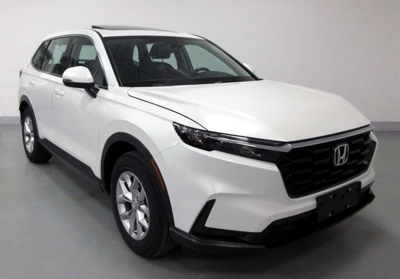

In [21]:
pred_class,_,probs = learn.predict(PILImage.create(images[1]))
print(f"Predicted: {pred_class}, actual: {brands[1]}.")
print(f"Probability it's a {brands[1]}: {probs[1]:.4f}")
Image.open(images[1]).to_thumb(400,400)

Predicted: Maserati, actual: Maserati.
Probability it's a Maserati: 1.0000


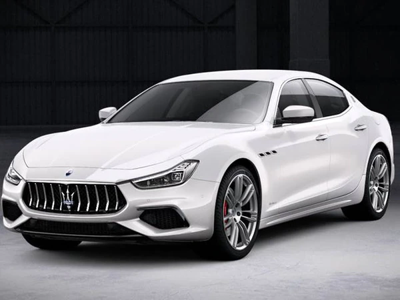

In [22]:
pred_class,_,probs = learn.predict(PILImage.create(images[2]))
print(f"Predicted: {pred_class}, actual: {brands[2]}.")
print(f"Probability it's a {brands[2]}: {probs[2]:.4f}")
Image.open(images[2]).to_thumb(400,400)

Predicted: Porsche, actual: Porsche.
Probability it's a Porsche: 1.0000


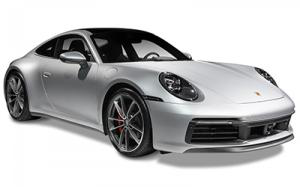

In [23]:
pred_class,_,probs = learn.predict(PILImage.create(images[3]))
print(f"Predicted: {pred_class}, actual: {brands[3]}.")
print(f"Probability it's a {brands[3]}: {probs[3]:.4f}")
Image.open(images[3]).to_thumb(400,400)

4 for 4 on our new images! This is pretty impressive considering our dataset did not include *any* cars from 2023. We can pull down a larger collection of 2023 images as a test set and test our model's accuracy against it:

In [25]:
path = Path('car_brands_test')

for brand in brands:
    p = path/brand
    dest = (p)
    dest.mkdir(parents=True, exist_ok=True)
    download_images(dest, urls=search_images(f'2023 {brand} "kbb.com"'), max_pics=100)
    sleep(10)
    resize_images(p, max_size=800, dest=p)
    
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#5) [None,None,None,None,None]

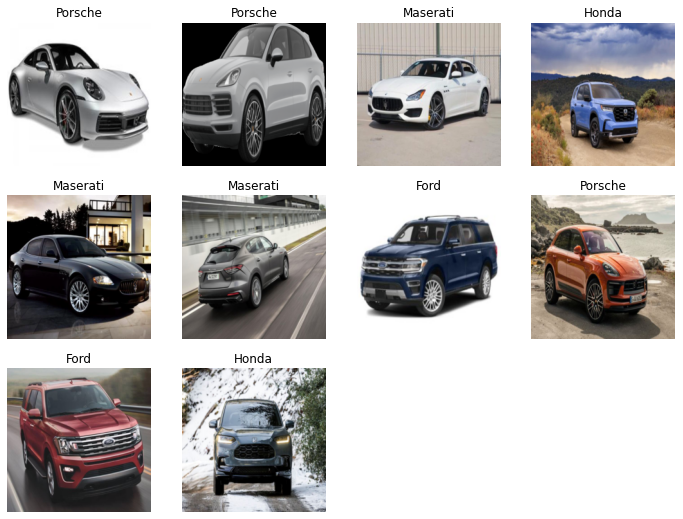

In [66]:
test_dl = learn.dls.test_dl(get_image_files(path), bs=32, with_labels=True, shuffle=True)
test_dl.show_batch(max_n=10)

In [72]:
preds, actuals = learn.get_preds(dl=test_dl)
error_rate(preds, actuals)

TensorBase(0.1842)

Seeing an accuracy of 82% is a bit disappointing given we saw much higher accuracy on our validation data while training our model. However, 82% is still pretty accurate and shows that our model is able to generalize well, even to brand new cars it has never seen before!

In this mini-project I succesfully applied *transfer learning* to an image classification problem and trained a model that was able to generalize well. I also learned a bit of the fast.ai library along the way. In the next lecture we cover ways to deploy a model and tactics to improve and evaluate model training.